# Logistic Regression Baseline Model Development
The purpose of this notebook is to explore preprocessing techniques beyond the simple data cleaning formalized in the notebook "EDA" (!!!hyperlink this!!!). 

My main goal is to discover the best sampling method to address the class imbalance present in the target variable.

I will also prototype various hyper parameter settings. 

## Load and clean data

In [1]:
from preprocessor import data_cleaner

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score,cross_val_predict


In [2]:
# import and define training data. See preprocessor.py file for details on data_cleaner()
X_train, y_train = data_cleaner("../data/train.csv.zip")

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 0 to 103903
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Age                                103904 non-null  int64  
 1   Flight Distance                    103904 non-null  int64  
 2   Inflight wifi service              103904 non-null  int64  
 3   Departure/Arrival time convenient  103904 non-null  int64  
 4   Ease of Online booking             103904 non-null  int64  
 5   Gate location                      103904 non-null  int64  
 6   Food and drink                     103904 non-null  int64  
 7   Online boarding                    103904 non-null  int64  
 8   Seat comfort                       103904 non-null  int64  
 9   Inflight entertainment             103904 non-null  int64  
 10  On-board service                   103904 non-null  int64  
 11  Leg room service                   1039

## Develop baseline model

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,classification_report, roc_curve,auc

In [5]:
def print_weights(y:np.array):
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    loyal_original = round(counts_train[0]/(counts_train[0]+counts_train[1]),3)
    disloyal_original = round(counts_train[1]/(counts_train[0]+counts_train[1]),3)

    unique_resample, counts_resample = np.unique(y, return_counts=True)
    loyal_resample = round(counts_resample[0]/(counts_resample[0]+counts_resample[1]),3)
    disloyal_resample = round(counts_resample[1]/(counts_resample[0]+counts_resample[1]),3)

    print('Original dataset weights:', loyal_original,disloyal_original)
    print('Original dataset size:',len(y_train))
    print('\nResample dataset weights', loyal_resample,disloyal_resample)
    print('Resample dataset size:', len(y_smote))

### fit estimator

In [6]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train,y_train)

y_train_pred = cross_val_predict(logreg,X_train,y_train)

train_score = cross_val_score(logreg,X_train,y_train_pred,scoring='f1')

In [7]:
train_score.mean()

0.9808701035069809

### print classification report

In [8]:
baseline_report = classification_report(y_train,y_train_pred,output_dict=True)
baseline_report = pd.DataFrame(baseline_report).iloc[:,0:3]
baseline_report

,0.0,1.0,accuracy
precision,0.933367,0.763805,0.905143
recall,0.951898,0.695959,0.905143
f1-score,0.942541,0.728305,0.905143
support,84923.000000,18981.000000,0.905143


### plot confusion matrix

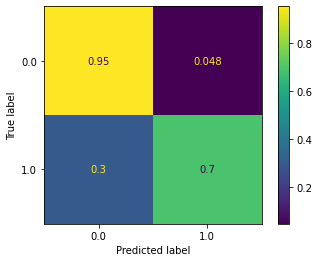

In [9]:
plot_confusion_matrix(logreg,X_train,y_train,normalize='true')
plt.show()

In [10]:
# Calculate the probability scores of each point in the training set
y_train_score = logreg.decision_function(X_train)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

In [11]:
baseline_auc = auc(train_fpr, train_tpr)

### calculate ROC AUC and plot curve

Training AUC: 0.9471699866930965


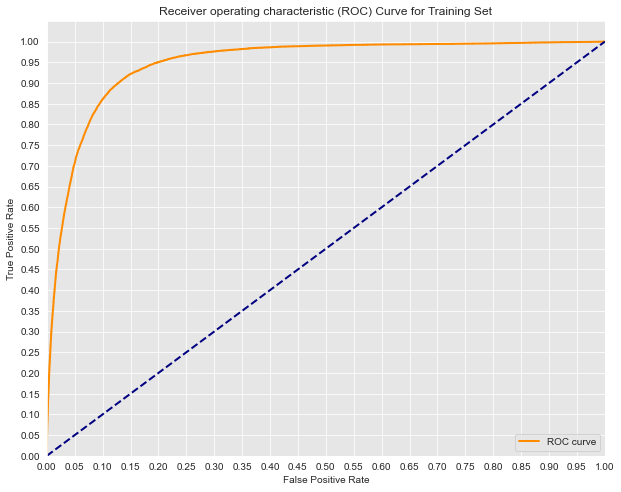

In [12]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

## Prototype sampling methods
- SMOTE (synthetic over sampling)
- Tomek Links (under sampling against decision boundary)
- Near Miss (distance based under sampling)
- Edited Nearest Neighbors (under samplin against decision boundary)
- SMOTETomek (SMOTE/Tomek Link ensemble)
- SMOETENN (SMOTE/Edited Nearest Neighbors Ensemble)

### SMOTE

##### resample data

In [13]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)


print_weights(y_smote)

Original dataset weights: 0.817 0.183
Original dataset size: 103904

Resample dataset weights 0.5 0.5
Resample dataset size: 169846


In [14]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(unique_elements)
print(counts_elements)

[0. 1.]
[84923 18981]


#### fit estimator

In [15]:
logreg_smote = LogisticRegression(solver='liblinear')
logreg_smote.fit(X_smote,y_smote)

smote_train_pred = logreg_smote.predict(X_smote)

smote_train_score = cross_val_score(logreg_smote,X_smote,smote_train_pred,scoring='f1',n_jobs=3)
print(smote_train_score.mean())

0.9944599766095351


#### plot confusion matrix

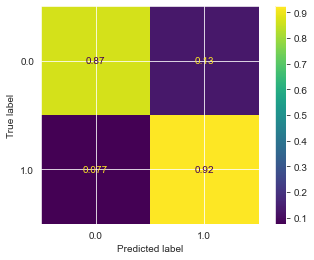

In [16]:
plot_confusion_matrix(logreg_smote,X_smote,y_smote,normalize='true')
plt.show()

#### print classification report

In [17]:
smote_report = classification_report(y_smote,smote_train_pred,output_dict=True)
smote_report = pd.DataFrame(smote_report).iloc[:,0:3]
smote_report

,0.0,1.0,accuracy
precision,0.919067,0.875912,0.896318
recall,0.869176,0.923460,0.896318
f1-score,0.893425,0.899058,0.896318
support,84923.000000,84923.000000,0.896318


#### calculate ROC AUC

In [18]:
# Calculate the probability scores of each point in the training set
y_smote_score = logreg_smote.decision_function(X_smote)
# Calculate the fpr, tpr, and thresholds for the training set
smote_fpr, smote_tpr, smote_thresholds = roc_curve(y_smote, y_smote_score)
smote_auc = auc(smote_fpr, smote_tpr)
print('Training AUC: {}'.format(smote_auc))

Training AUC: 0.9501178971660749


### Tomek Links

#### resample data

In [19]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='majority',n_jobs=3)
X_tl, y_tl = tl.fit_resample(X_train, y_train)

print_weights(y_tl)

Original dataset weights: 0.817 0.183
Original dataset size: 103904

Resample dataset weights 0.809 0.191
Resample dataset size: 169846


#### fit estimator

In [20]:
logreg_tl = LogisticRegression(solver='liblinear')
logreg_tl.fit(X_tl,y_tl)

tl_train_pred = logreg_tl.predict(X_tl)

tl_train_score = cross_val_score(logreg_tl,X_tl,y_tl,n_jobs=3,scoring='f1')
print(tl_train_score.mean())

0.7508259263452878


#### plot confusion matrix

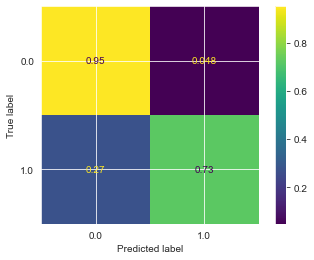

In [21]:
plot_confusion_matrix(logreg_tl,X_tl,y_tl,normalize='true')
plt.show()

#### print classification report

In [22]:
tomek_report = classification_report(y_tl,tl_train_pred,output_dict=True)
tomek_report = pd.DataFrame(tomek_report).iloc[:,0:3]
tomek_report

,0.0,1.0,accuracy
precision,0.936407,0.781099,0.90891
recall,0.952116,0.725462,0.90891
f1-score,0.944196,0.752253,0.90891
support,80591.000000,18981.000000,0.90891


#### calculate ROC AUC

In [23]:
# Calculate the probability scores of each point in the training set
y_tomek_score = logreg_smote.decision_function(X_tl)
# Calculate the fpr, tpr, and thresholds for the training set
tl_fpr , tl_tpr, tomek_thresholds = roc_curve(y_tl, y_tomek_score)
tl_auc = auc(tl_fpr, tl_tpr)
print('Training AUC: {}'.format(tl_auc))

Training AUC: 0.9439161672152295


### Near Miss

#### resample the data

In [24]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(sampling_strategy='all',n_jobs=3)
X_nm, y_nm = nm.fit_resample(X_train,y_train)

print_weights(y_nm)

Original dataset weights: 0.817 0.183
Original dataset size: 103904

Resample dataset weights 0.5 0.5
Resample dataset size: 169846


#### fit estimator

In [25]:
logreg_nm = LogisticRegression(solver='liblinear')
logreg_nm.fit(X_nm,y_nm)

nm_train_pred = logreg_nm.predict(X_nm)

nm_train_score = cross_val_score(logreg_nm,X_nm,y_nm,n_jobs=3,scoring='f1')
print(nm_train_score.mean())

0.869810080157241


#### plot confusion matrix

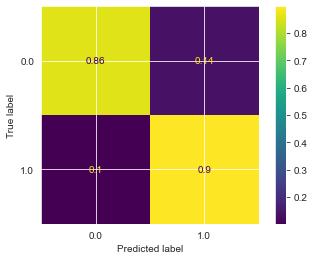

In [26]:
plot_confusion_matrix(logreg_nm,X_nm,y_nm,normalize='true')
plt.show()

#### print classification report

In [27]:
nm_report = classification_report(y_nm,nm_train_pred,output_dict=True)
nm_report = pd.DataFrame(nm_report).iloc[:,0:3]
nm_report

,0.0,1.0,accuracy
precision,0.893693,0.864455,0.87851
recall,0.859228,0.897793,0.87851
f1-score,0.876121,0.880808,0.87851
support,18981.000000,18981.000000,0.87851


#### calculate ROC AUC

In [28]:
# Calculate the probability scores of each point in the training set
y_nm_score  = logreg_nm.decision_function(X_nm)
# Calculate the fpr, tpr, and thresholds for the training set
nm_fpr , nm_tpr, nm_thresholds = roc_curve(y_nm, y_nm_score )
nm_auc = auc(nm_fpr, nm_tpr)
print('Training AUC: {}'.format(nm_auc))

Training AUC: 0.9492465604949281


### Edited Nearest Neighbors

#### resample the data

In [29]:
from imblearn.under_sampling import EditedNearestNeighbours
ENN = EditedNearestNeighbours(sampling_strategy='majority')
X_enn, y_enn = ENN.fit_resample(X_train,y_train)

print_weights(y_enn)

Original dataset weights: 0.817 0.183
Original dataset size: 103904

Resample dataset weights 0.762 0.238
Resample dataset size: 169846


#### fit estimator

In [30]:
logreg_ENN = LogisticRegression(solver='liblinear')
logreg_ENN.fit(X_enn,y_enn)

enn_train_pred = cross_val_predict(logreg_ENN,X_enn,y_enn,n_jobs=3)

enn_train_score = cross_val_score(logreg_ENN,X_enn,y_enn,n_jobs=3,scoring='f1')
print(enn_train_score.mean())

0.8373544378234661


#### plot confusion matrix

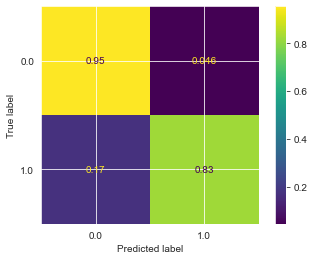

In [31]:
plot_confusion_matrix(logreg_ENN,X_enn,y_enn,normalize='true')
plt.show()

#### print classification matrix

In [32]:
enn_report = classification_report(y_enn,enn_train_pred,output_dict=True)
enn_report = pd.DataFrame(enn_report).iloc[:,0:3]
enn_report

,0.0,1.0,accuracy
precision,0.946071,0.848785,0.923498
recall,0.953933,0.826247,0.923498
f1-score,0.949986,0.837365,0.923498
support,60651.000000,18981.000000,0.923498


#### calculate ROC AUC

In [33]:
# Calculate the probability scores of each point in the training set
y_enn_score  = logreg_nm.decision_function(X_enn)
# Calculate the fpr, tpr, and thresholds for the training set
enn_fpr , enn_tpr, enn_thresholds = roc_curve(y_enn, y_enn_score )
enn_auc = auc(enn_fpr, enn_tpr)
print('Training AUC: {}'.format(enn_auc))

Training AUC: 0.7846937445781219


### SMOTETomek

#### resample the data

In [34]:
from imblearn.combine import SMOTETomek
SMOTek = SMOTETomek(sampling_strategy='all',smote=smote,tomek=tl,n_jobs=3)
X_smotek, y_smotek = SMOTek.fit_resample(X_train,y_train)

print_weights(y_smotek)

Original dataset weights: 0.817 0.183
Original dataset size: 103904

Resample dataset weights 0.499 0.501
Resample dataset size: 169846


#### fit estimator

In [35]:
logreg_SMOTek = LogisticRegression(solver='liblinear')
logreg_SMOTek.fit(X_smotek,y_smotek)

smotek_train_pred = logreg_SMOTek.predict(X_smotek)

smotek_train_score = cross_val_score(logreg_SMOTek,X_smotek,y_smotek,n_jobs=3,scoring='f1')
print(smotek_train_score.mean())

0.8972609324005788


#### plot confusion matrix

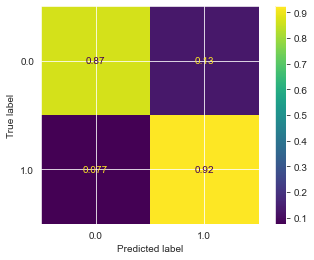

In [36]:
plot_confusion_matrix(logreg_SMOTek,X_smotek,y_smotek,normalize='true')
plt.show()

#### print classification report

In [37]:
smotek_report = classification_report(y_nm,nm_train_pred,output_dict=True)
smotek_report = pd.DataFrame(smotek_report).iloc[:,0:3]
smotek_report

,0.0,1.0,accuracy
precision,0.893693,0.864455,0.87851
recall,0.859228,0.897793,0.87851
f1-score,0.876121,0.880808,0.87851
support,18981.000000,18981.000000,0.87851


#### calculate ROC AUC

In [38]:
# Calculate the probability scores of each point in the training set
y_smotek_score  = logreg_SMOTek.decision_function(X_smotek)
# Calculate the fpr, tpr, and thresholds for the training set
smotek_fpr , smotek_tpr, smotek_thresholds = roc_curve(y_smotek, y_smotek_score )
smotek_auc = auc(smotek_fpr, smotek_tpr)
print('Training AUC: {}'.format(smotek_auc))

Training AUC: 0.9500785179113276


### SMOTENN

#### resmaple the data

In [39]:
from imblearn.combine import SMOTEENN
SMN = SMOTEENN(sampling_strategy='all',smote=smote,enn=ENN,n_jobs=3)
X_smn, y_smn = SMN.fit_resample(X_train,y_train)

print_weights(y_smn)

Original dataset weights: 0.817 0.183
Original dataset size: 103904

Resample dataset weights 0.382 0.618
Resample dataset size: 169846


#### fit estimator

In [40]:
logreg_SMOTENN = LogisticRegression(solver='liblinear')
logreg_SMOTENN.fit(X_smn,y_smn)

smn_train_pred = logreg_SMOTENN.predict(X_smn)

smn_train_score = cross_val_score(logreg_SMOTENN,X_smn,y_smn,n_jobs=3,scoring='f1')
print(smn_train_score.mean())

0.9425697164915263


#### plot confusion matrix

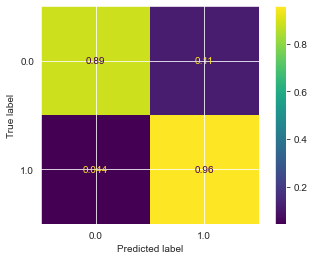

In [41]:
plot_confusion_matrix(logreg_SMOTENN,X_smn,y_smn,normalize='true')
plt.show()

#### print classification report

In [42]:
SMOTENN_report = classification_report(y_smn,smn_train_pred,output_dict=True)
SMOTENN_report = pd.DataFrame(SMOTENN_report).iloc[:,0:3]
SMOTENN_report

,0.0,1.0,accuracy
precision,0.925627,0.931012,0.929044
recall,0.885412,0.956019,0.929044
f1-score,0.905073,0.943350,0.929044
support,52501.000000,84923.000000,0.929044


#### calculate ROC AUC

In [43]:
# Calculate the probability scores of each point in the training set
SMOTENN_score  = logreg_SMOTENN.decision_function(X_smn)
# Calculate the fpr, tpr, and thresholds for the training set
smotenn_fpr , smotenn_tpr, smotenn_thresholds = roc_curve(y_smn, SMOTENN_score)
smotenn_auc = auc(smotenn_fpr, smotenn_tpr)
print('Training AUC: {}'.format(smotenn_auc))

Training AUC: 0.9727681543695383


## Validate sample and select method(s)
- First tried SMOTENN because it had the highest F1, validation however had a ROC AUC of about .06, indicating the model is overfitting the data. 
- Next I am trying Near Miss because it only undersamples the majority and had a training F1 score between SMOTE and Edited Nearest Neighbors, the two methods used in SMOTENN. Not synthesizing new data, and only undersampling I expect will reduce overfitting. 

In [44]:
# load and clean validation set
X_test, y_test = data_cleaner("../data/train.csv.zip")

### SMOTENN CV Test

#### fit cross validated model

In [45]:
logreg_SMOTENN_CV = LogisticRegressionCV(solver='liblinear',n_jobs=3)
logreg_SMOTENN_CV.fit(X_smn,y_smn)

LogisticRegressionCV(n_jobs=3, solver='liblinear')

In [46]:
smn_test_pred = logreg_SMOTENN_CV.predict(X_test)
smn_test_report = classification_report(y_test,smn_test_pred,output_dict=True)
SMOTENN_CV_report = pd.DataFrame(smn_test_report).iloc[:,0:3]
SMOTENN_CV_report

,0.0,1.0,accuracy
precision,0.983513,0.539741,0.842566
recall,0.821144,0.938412,0.842566
f1-score,0.895024,0.685314,0.842566
support,84923.000000,18981.000000,0.842566


#### plot confusion matrix

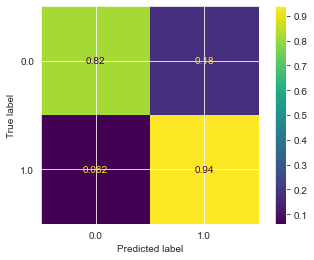

In [47]:
# plot confusion matrix
plot_confusion_matrix(logreg_SMOTENN_CV,X_test,y_test,normalize='true')
plt.show()

#### plot ROC AUC

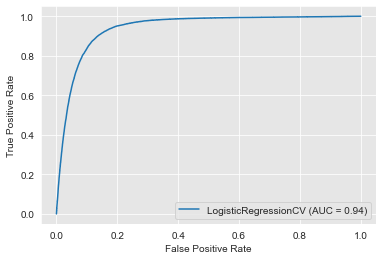

In [48]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(logreg_SMOTENN_CV,X_test,y_test)
plt.show()

In [49]:
# Calculate the probability scores of each point in the training set
SMOTENN_CV_score  = logreg_SMOTENN_CV.decision_function(X_test)
# Calculate the fpr, tpr, and thresholds for the training set
smotenn_cv_fpr , smotenn_cv_tpr, smotenn_cv_thresholds = roc_curve(y_test, SMOTENN_CV_score)
smotenn_cv_auc = auc(smotenn_cv_fpr, smotenn_cv_tpr)
print('SMOTENN Test AUC: {}'.format(smotenn_cv_auc))

SMOTENN Test AUC: 0.9395813825932257


### SMOTE CV Test

In [50]:
logreg_SMOTE_CV = LogisticRegressionCV(solver='liblinear',n_jobs=3)
logreg_SMOTE_CV.fit(X_smote,y_smote)

LogisticRegressionCV(n_jobs=3, solver='liblinear')

In [51]:
smote_test_pred = logreg_SMOTE_CV.predict(X_test)
smote_test_report = classification_report(y_test,smote_test_pred,output_dict=True)
SMOTE_CV_report = pd.DataFrame(smote_test_report).iloc[:,0:3]
SMOTE_CV_report

,0.0,1.0,accuracy
precision,0.973479,0.603628,0.873402
recall,0.868775,0.894105,0.873402
f1-score,0.918152,0.720698,0.873402
support,84923.000000,18981.000000,0.873402


#### plot confusion matrix

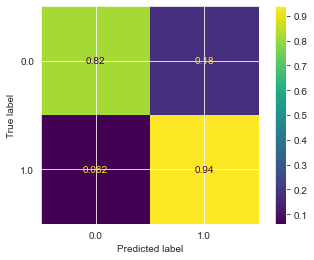

In [52]:
# plot confusion matrix
plot_confusion_matrix(logreg_SMOTENN_CV,X_test,y_test,normalize='true')
plt.show()

#### plot ROC AUC

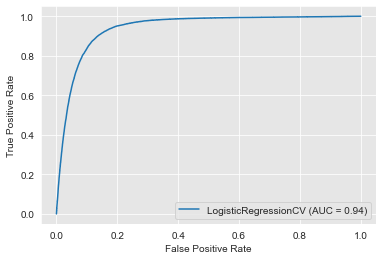

In [53]:
plot_roc_curve(logreg_SMOTENN_CV,X_test,y_test)
plt.show()

In [60]:
# Calculate the probability scores of each point in the training set
SMOTE_CV_score  = logreg_SMOTE_CV.decision_function(X_test)
# Calculate the fpr, tpr, and thresholds for the training set
smote_cv_fpr , smote_cv_tpr, smote_cv_thresholds = roc_curve(y_test, SMOTE_CV_score)
smote_cv_auc = auc(smote_cv_fpr, smote_cv_tpr)
print('SMOTE Test AUC: {}'.format(smote_cv_auc))

SMOTE Test AUC: 0.9402851542213703


### Near Miss CV Test

#### fit cross validated model

In [54]:
logreg_nm_cv = LogisticRegressionCV(solver='liblinear',n_jobs=3)
logreg_nm_cv.fit(X_nm,y_nm)

nm_test_pred = logreg_nm_cv.predict(X_test)
nm_test_report = classification_report(y_test,nm_test_pred,output_dict=True)
nm_test_report = pd.DataFrame(nm_test_report).iloc[:,0:3]
nm_test_report

,0.0,1.0,accuracy
precision,0.965721,0.354473,0.682428
recall,0.633951,0.899320,0.682428
f1-score,0.765431,0.508512,0.682428
support,84923.000000,18981.000000,0.682428


#### plot confusion matrix

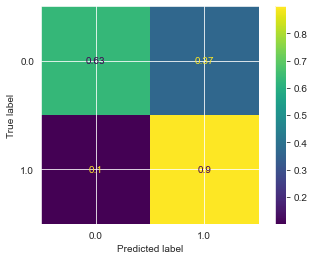

In [55]:
plot_confusion_matrix(logreg_nm_cv,X_test,y_test,normalize='true')
plt.show()

#### plot ROC AUC

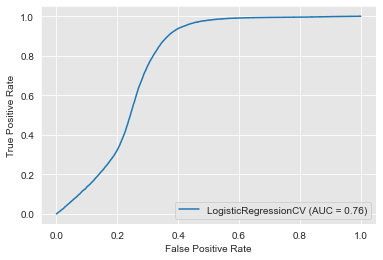

In [56]:
plot_roc_curve(logreg_nm_cv,X_test,y_test)
plt.show()

In [57]:
# Calculate the probability scores of each point in the training set
nm_cv_score  = logreg_nm_cv.decision_function(X_test)
# Calculate the fpr, tpr, and thresholds for the training set
nm_cv_fpr , nm_cv_tpr, nm_cv_thresholds = roc_curve(y_test, nm_cv_score)
nm_cv_auc = auc(nm_cv_fpr, nm_cv_tpr)
print('Near Miss Test AUC: {}'.format(nm_cv_auc))

Near Miss Test AUC: 0.7619659221996201


## Visualize F1, ROC AUC iterative performance

In [67]:
f1_dict = {
    'baseline':baseline_report.iloc[2,1],
    'SMOTE':smote_report.iloc[2,1],
    'Tomek Links':tomek_report.iloc[2,1],
    'Near\nMiss':nm_report.iloc[2,1],
    'ENN':enn_report.iloc[2,1],
    'SMOTETomek':smotek_report.iloc[2,1],
    'SMOTENN':SMOTENN_report.iloc[2,1],
    'SMOTENN\nTest':SMOTENN_CV_report.iloc[2,1],
    'SMOTE CV\nTest':SMOTE_CV_report.iloc[2,1],
    'Near Miss\nTest':nm_test_report.iloc[2,1]
}
f1_dict = dict(sorted(f1_dict.items(), key=lambda item: item[1],reverse=True))

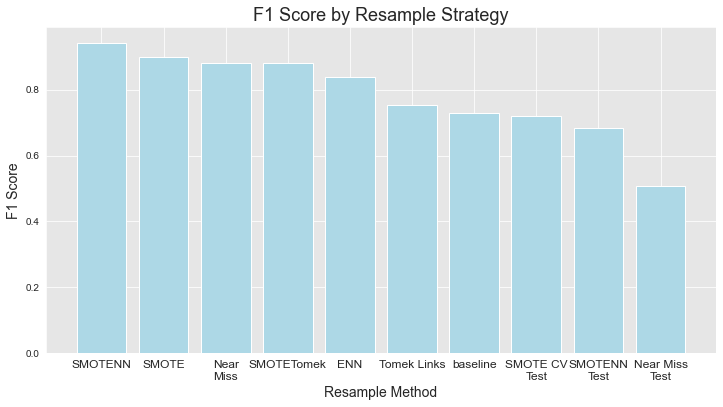

In [68]:
plt.figure(figsize=(12,6))
plt.bar(x=f1_dict.keys(),height=f1_dict.values(),color='lightblue')
plt.ylabel('F1 Score',fontsize=14)
plt.xlabel('Resample Method',fontsize=14)
plt.xticks(fontsize=12)
plt.title("F1 Score by Resample Strategy",fontsize=18)
plt.show()

In [61]:
roc_auc_scores = [
    baseline_auc,
    smote_auc,
    tl_auc,
    nm_auc,
    enn_auc,
    smotek_auc,
    smotenn_auc,
    smotenn_cv_auc,
    smote_cv_auc,
    nm_cv_auc
]
np.mean(roc_auc_scores)

0.9139823487442532

#### plot ROC AUC curves

Baseline Model AUC: 0.9471699866930965
SMOTE resample AUC: 0.9501178971660749
Tomek Links AUC: 0.9439161672152295
Near Miss AUC: 0.9492465604949281
Edited Nearest Neighbors AUC: 0.7846937445781219
SMOTETomek AUC: 0.9500785179113276
SMOTEENN AUC: 0.9727681543695383


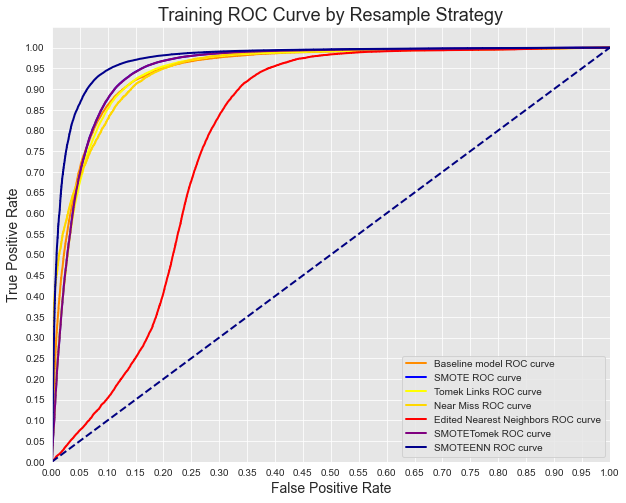

In [62]:
plt.figure(figsize=(10,8))
lw = 2

print('Baseline Model AUC: {}'.format(baseline_auc))
print('SMOTE resample AUC: {}'.format(smote_auc))

plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='Baseline model ROC curve')
plt.plot(smote_fpr, smote_tpr, color='blue',
         lw=lw, label='SMOTE ROC curve')


print('Tomek Links AUC: {}'.format(tl_auc))
print('Near Miss AUC: {}'.format(nm_auc))

plt.plot(tl_fpr, tl_tpr, color='yellow',
         lw=lw, label='Tomek Links ROC curve')
plt.plot(nm_fpr, nm_tpr, color='gold',
         lw=lw, label='Near Miss ROC curve')


print('Edited Nearest Neighbors AUC: {}'.format(enn_auc))
print('SMOTETomek AUC: {}'.format(smotek_auc))

plt.plot(enn_fpr, enn_tpr, color='red',
         lw=lw, label='Edited Nearest Neighbors ROC curve')
plt.plot(smotek_fpr, smotek_tpr, color='purple',
         lw=lw, label='SMOTETomek ROC curve')


print('SMOTEENN AUC: {}'.format(smotenn_auc))
plt.plot(smotenn_fpr, smotenn_tpr, color='darkblue',
         lw=lw, label='SMOTEENN ROC curve')


# Formatting
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('Training ROC Curve by Resample Strategy',fontsize=18)
plt.legend(loc="lower right")
plt.show()

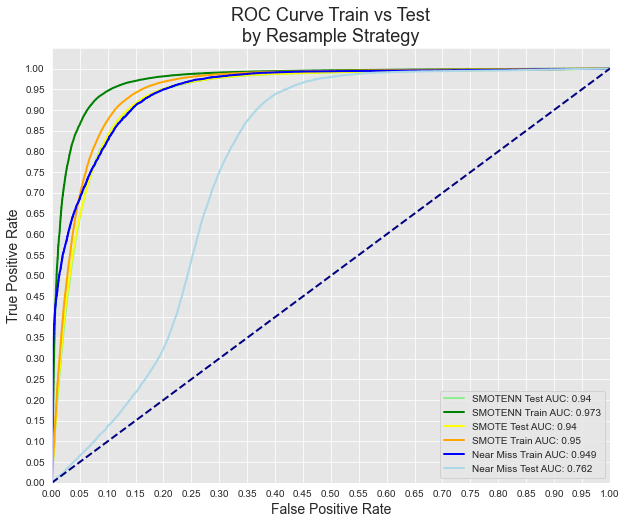

In [70]:
plt.figure(figsize=(10,8))
lw = 2

plt.plot(smotenn_cv_fpr, smotenn_cv_tpr, color='lightgreen',
         lw=lw, label=f'SMOTENN Test AUC: {round(smotenn_cv_auc,3)}')
plt.plot(smotenn_fpr,smotenn_tpr,color='green',
         lw=lw, label=f'SMOTENN Train AUC: {round(smotenn_auc,3)}')

plt.plot(smote_cv_fpr, smote_cv_tpr, color='yellow',
         lw=lw, label=f'SMOTE Test AUC: {round(smote_cv_auc,3)}')
plt.plot(smote_fpr,smote_tpr,color='orange',
         lw=lw, label=f'SMOTE Train AUC: {round(smote_auc,3)}')

plt.plot(nm_fpr, nm_tpr, color='blue',
         lw=lw, label=f'Near Miss Train AUC: {round(nm_auc,3)}')
plt.plot(nm_cv_fpr, nm_cv_tpr, color='lightblue',
         lw=lw, label=f'Near Miss Test AUC: {round(nm_cv_auc,3)}')

# Formatting
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('ROC Curve Train vs Test\nby Resample Strategy',fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Final Observations

My initial analysis was that SMOTEENN was the strongest performer of all the resample strategies presented here. That is indeed true on the test data alone. Classic SMOTE the second strongest performer on the training data, and performs on the test data *nearly* as well as SMOTEENN, in fact their ROC AUC scores are exactly the same. The difference in F1-score between SMOTE and SMOTEENN is only about 0.04. However the difference in F1 score between train and test for SMOTEENN is 0.26, while the difference for SMOTE is only about 0.18 (see cells below). In other words, in terms of F1-score, SMOTE performs about 8% better than SMOTEENN. The difference is not massive but enough to reconsider SMOTE in lieu of SMOTEENN as the resample strategy to be used moving forward.

In the next development notebook I will use the preprocessing from EDA, and the SMOTE resampling method found here to train and optimize via gridsearching a decision tree and/or random forest. To use as my final model.

In [78]:
# difference in F1 for classic SMOTE and SMOTEENN
SMOTE_CV_report.iloc[2,1] - SMOTENN_CV_report.iloc[2,1]

0.035384001257912745

In [81]:
# difference in F1 for classic SMOTE train vs test
SMOTENN_report.iloc[2,1] - SMOTENN_CV_report.iloc[2,1]

0.25803582113253065

In [82]:
# difference in F1 for classic SMOTE train vs test
smote_report.iloc[2,1] - SMOTE_CV_report.iloc[2,1]

0.17835949357883185